# Preparing data

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from nltk.corpus import wordnet

In [3]:
def get_synonyms(ofword):
  from nltk.corpus import wordnet
  synonyms = []

  for syn in wordnet.synsets(ofword):
    for l in syn.lemmas():
      synonyms.append(l.name())

  return synonyms

In [4]:
def get_antonyms(ofword):
  from nltk.corpus import wordnet
  antonyms = []

  for syn in wordnet.synsets(ofword):
    for l in syn.lemmas():
      if l.antonyms():
          antonyms.append(l.antonyms()[0].name())

  return antonyms
  # print(set(antonyms))

In [5]:
synonyms = get_synonyms("active")
print (synonyms)

['active_agent', 'active', 'active_voice', 'active', 'active', 'active', 'active', 'combat-ready', 'fighting', 'active', 'active', 'participating', 'active', 'active', 'active', 'active', 'alive', 'active', 'active', 'active', 'dynamic', 'active', 'active', 'active']


In [6]:
# read the words to list
with open('vagueWords.txt') as vague_word_list_file:
    vague_word_list = vague_word_list_file.read().splitlines()

vague_word_set = set()

# Add the synonyms of each word
for vagueword in vague_word_list:
  for vague_word_synonym in get_synonyms(vagueword):
    vague_word_set.add(vague_word_synonym.lower())

# Add the antonyms( of each word 
for vagueword in vague_word_list:
  for vague_word_synonym in get_antonyms(vagueword):
    vague_word_set.add(vague_word_synonym.lower())

# Remove unncessary words
remove_word_list = ['adept']
for word in remove_word_list:
  if word in vague_word_set:
    vague_word_set.remove(word)

# Add words without adding synonyms
addtional_word_list = ['didnt', 'doesnt']
for word in addtional_word_list:
  vague_word_set.add(word)

vague_word_set = sorted(vague_word_set)

vague_word_list = list(vague_word_set)

print('No. of vague words =', len(vague_word_list))

No. of vague words = 357


In [7]:
import json
reviews = []
with open('reviews.json') as file:
  for line in file:
      entry = json.loads(line)
      reviews.append(entry["_source"]["review"])

print("Total No. of reviews =", len(reviews))

Total No. of reviews = 140590


# Sentence Tokenization

In [8]:
from nltk.tokenize import sent_tokenize

In [9]:
sentences_set = set()
for review in reviews:
  for sentence in sent_tokenize(review):
    sentences_set.add(sentence.lower())
sentences = list(sentences_set) 

# Removing stop words

In [10]:
def get_stopwords():
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  stopwords = set(stopwords.words('english'))
  # read the words to list
  with open('stopwords.txt') as stop_word_list_file:
    for word in stop_word_list_file.read().splitlines():
      stopwords.add(word.lower())

  additional_words = ["hi", "ok", "am", "would", "i'm","im","ill","cant","else","youd","otherwise","due"
  ,"youre","ive","havent","hasnt","hadnt","didnt","could","doesnt","may","wouldnt","dont","cant","could"
  ,"every","anyone","say","isnt","arent","also","cannot","itll","lets","youll","aspacingtopmini","hello"
  ,"theres","itthe","shes","hes","another","etc"]
  for word in additional_words:
    stopwords.add(word)
  return stopwords

In [11]:
import re
from collections import defaultdict
reviews = sentences
reviews = [re.sub(r'[^\w\s]','',str(item)) for item in reviews]
stopwords = get_stopwords()
texts = [[word for word in document.lower().split() if word not in stopwords] for document in reviews]
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Transforming reviews into input data text file 

In [12]:
def write_inputstxt(inputs):
  file1 = open("input.txt", "a")  # append mode
  for text in texts:
    file1.write(' '.join(text) + "\n")
    
  file1.close()
write_inputstxt(texts)

# Choosing the number of topics

In [13]:
cluster_count = "15"

Running the Brown Clustering algorithm

In [14]:
import subprocess
subprocess.call(["/static/brown-cluster-master/wcluster", "--text", "/content/input.txt", "--c", cluster_count])

0

Reading the results of the Brown Clustering algorithm 

In [15]:
import pandas as pd

df = pd.read_csv(f'/content/input-c{cluster_count}-p1.out/paths',  sep='\t', header=None, names=['cluster', "word", "frequency"],  dtype={'cluster': str,'word':str, "frequency": int},index_col=False)
df.reset_index(drop=True, inplace=True)
df.sort_values(["frequency"], ascending = (False), inplace=True)

In [16]:
df.head() #showing sample of the data (first five rows)

,cluster,word,frequency
25849,0110,laptop,88049
25850,0110,computer,41621
42233,11110,screen,33568
35516,101,great,33120
19183,0100,use,32929


In [17]:
print(df.cluster.unique(), len(df.cluster.unique()))#Unique clusters

['0110' '11110' '101' '0100' '100' '0011' '00011' '0000' '110' '1110'
 '0101' '0010' '11111' '0111' '00010'] 15


Calculating the words frequencies in a topic

In [18]:
def get_words(cluster, df):
  df1 = df[df["cluster"] == cluster]
  return df1.set_index("word").to_dict()['frequency']

In [19]:
print(get_words("000", df).items()) #example 

dict_items([])


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import json
import math
import re # We clean text using regex
import csv # To read the csv
from collections import defaultdict # For accumlating values
import matplotlib.colors as mcolors
from collections import Counter

# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# % matplotlib inline

# Word cloud

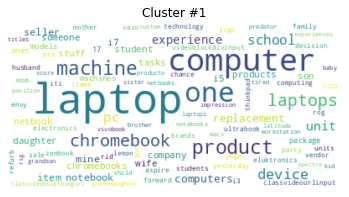

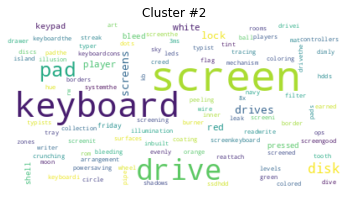

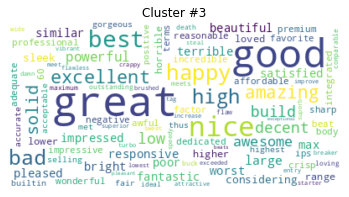

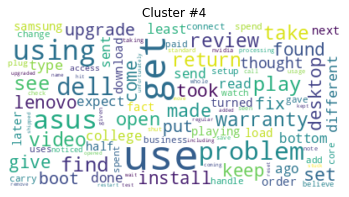

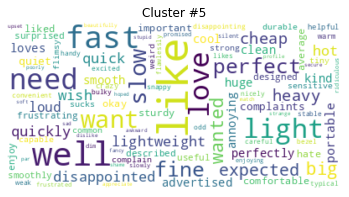

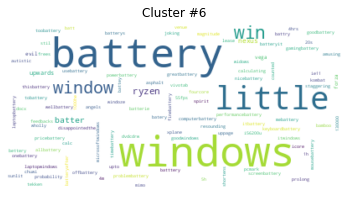

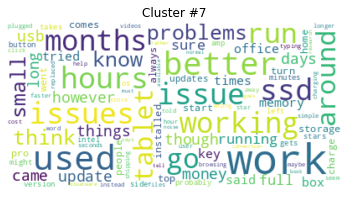

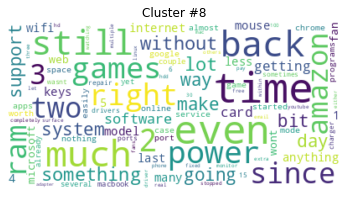

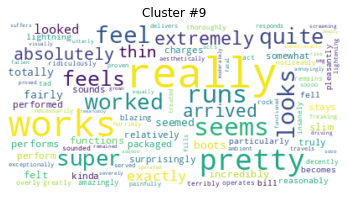

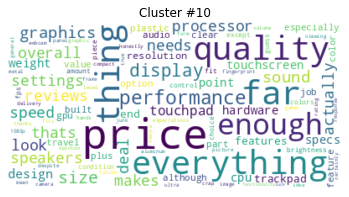

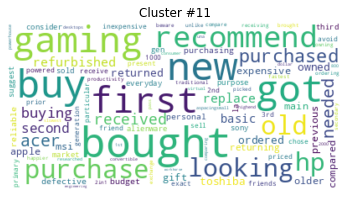

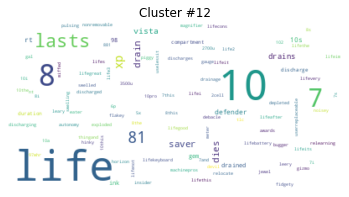

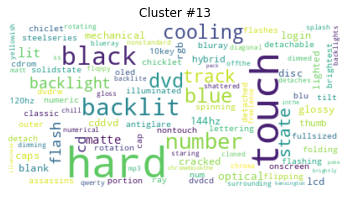

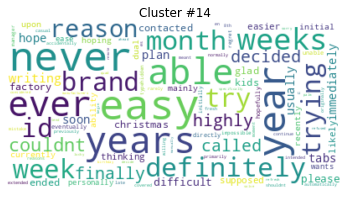

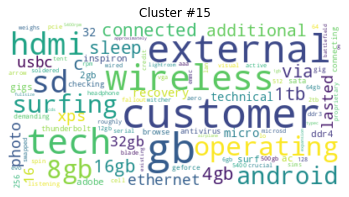

In [21]:
import matplotlib.pyplot as plt
for cluster_index, cluster_value in enumerate(df.cluster.unique()):
    plt.figure()
    plt.imshow(WordCloud(max_font_size=50, max_words=100, background_color="white").fit_words(get_words(cluster_value,df)),interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster #" + str(cluster_index+1))
    plt.show()


Preparing pandas dataframe for processing

In [22]:
def get_topics(df):
  my_list = []
  for i, value in enumerate(df.cluster.unique()):
    a_view = get_words(value, df).items()
    a_list = list(a_view)
    my_tuple = (i, a_list[:20])
    my_list.append(my_tuple)
  return my_list

topics = get_topics(df)

# Calculating the Vagueness degree

In [23]:
def sum_of_frequency_of_words_in_topic(topic_index, topics):
  sum = 0
  for index, value in enumerate(topics[topic_index][1]):
    sum += value[1]
    # print(value)
  return sum

def sum_of_frequency_of_vague_words_in_topic(vague_word_list, topic_index, topics):
  sum = 0
  for index, value in enumerate(topics[topic_index][1]):
    if value[0] in vague_word_list:
      sum += value[1]
      # print(value)
  return sum  

def vagueness_degree(vague_word_list):
  for i in range(len(topics)):
    all_word_count = sum_of_frequency_of_words_in_topic(i, topics)
    vague_word_count = sum_of_frequency_of_vague_words_in_topic(vague_word_list, i, topics)
    percentage = round(vague_word_count / all_word_count * 10000) / 100
    percentage_str = "percentage: " + str(percentage) + "%"
    if percentage >= 10.00:
      print("topic", f'{i:<2}', f'{"vague: " + str(vague_word_count):<15}', f'{"all: " + str(all_word_count):<15}', f'{percentage_str:<20}', "vague")
    else:
      print("topic", f'{i:<2}', f'{"vague: " + str(vague_word_count):<15}', f'{"all: " + str(all_word_count):<15}', f'{percentage_str:<20}')


      


vagueness_degree(vague_word_list)


topic 0  vague: 3832     all: 249840     percentage: 1.53%   
topic 1  vague: 0        all: 85261      percentage: 0.0%    
topic 2  vague: 61163    all: 140382     percentage: 43.57%   vague
topic 3  vague: 12507    all: 175629     percentage: 7.12%   
topic 4  vague: 58453    all: 166180     percentage: 35.17%   vague
topic 5  vague: 52       all: 62661      percentage: 0.08%   
topic 6  vague: 35996    all: 176115     percentage: 20.44%   vague
topic 7  vague: 8711     all: 201855     percentage: 4.32%   
topic 8  vague: 15183    all: 99896      percentage: 15.2%    vague
topic 9  vague: 28177    all: 140110     percentage: 20.11%   vague
topic 10 vague: 14057    all: 156345     percentage: 8.99%   
topic 11 vague: 0        all: 37349      percentage: 0.0%    
topic 12 vague: 0        all: 40902      percentage: 0.0%    
topic 13 vague: 8153     all: 85884      percentage: 9.49%   
topic 14 vague: 0        all: 38801      percentage: 0.0%    


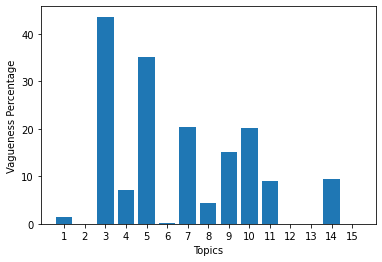

In [24]:
def plot_topic_percentage(topics):
  topic_rankings_x = []
  topic_rankings_y = []
  for i in range(len(topics)):
    all_word_count = sum_of_frequency_of_words_in_topic(i, topics)
    vague_word_count = sum_of_frequency_of_vague_words_in_topic(vague_word_list, i, topics)
    percentage = round(vague_word_count / all_word_count * 100, 2)
    topic_rankings_x.append(i + 1)
    topic_rankings_y.append(percentage)
    # print(percentage)

  plt.yticks(np.arange(0, 100, 10))
  plt.xticks(np.arange(1, len(topics) + 1, 1))
  plt.bar(topic_rankings_x, topic_rankings_y)
  plt.ylabel('Vagueness Percentage')
  plt.xlabel('Topics')
  plt.show()
plot_topic_percentage(topics)

# Words in vague topics

In [25]:
def print_vague_topic_words(vague_word_list):
  for i in range(len(topics)):
    all_word_count = sum_of_frequency_of_words_in_topic(i, topics)
    vague_word_count = sum_of_frequency_of_vague_words_in_topic(vague_word_list, i, topics)
    percentage = round(vague_word_count / all_word_count * 10000) / 100
    if percentage >= 10.00:
      print("\ntopic", i)
      for index, value in enumerate(topics[i][1]):
        print("             " + f'{value[0]:<14}', value[1])
print_vague_topic_words(vague_word_list)


topic 2
             great          33120
             good           29571
             nice           11371
             best           7887
             happy          6558
             bad            6209
             high           5567
             excellent      4710
             amazing        4350
             solid          4023
             low            3376
             decent         3362
             build          3337
             awesome        3052
             powerful       2763
             large          2502
             beautiful      2297
             pleased        2189
             responsive     2106
             bright         2032

topic 4
             like           29913
             well           17635
             fast           15231
             need           12628
             love           11524
             light          10864
             want           9023
             slow           8511
             perfect        6961
             fin

Bar plot of top 20 words with their weights

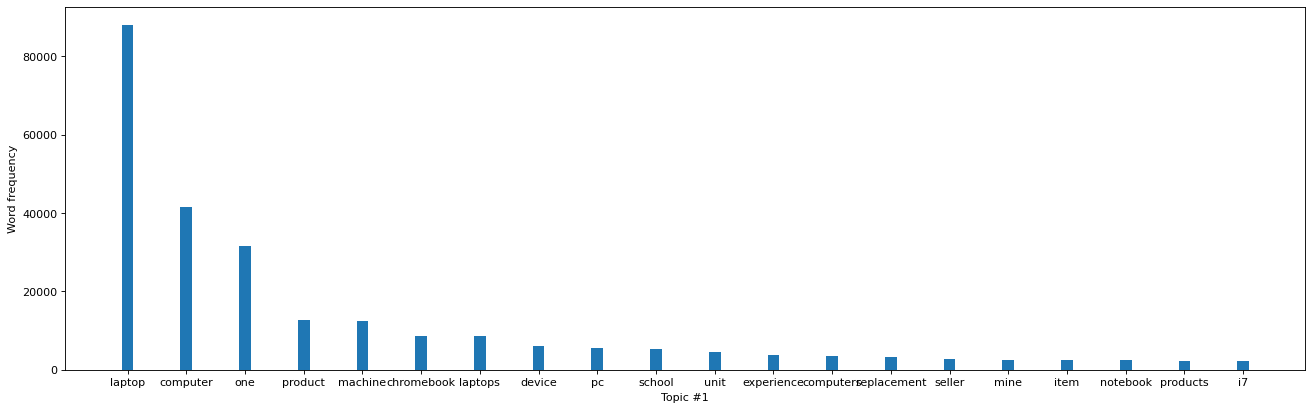

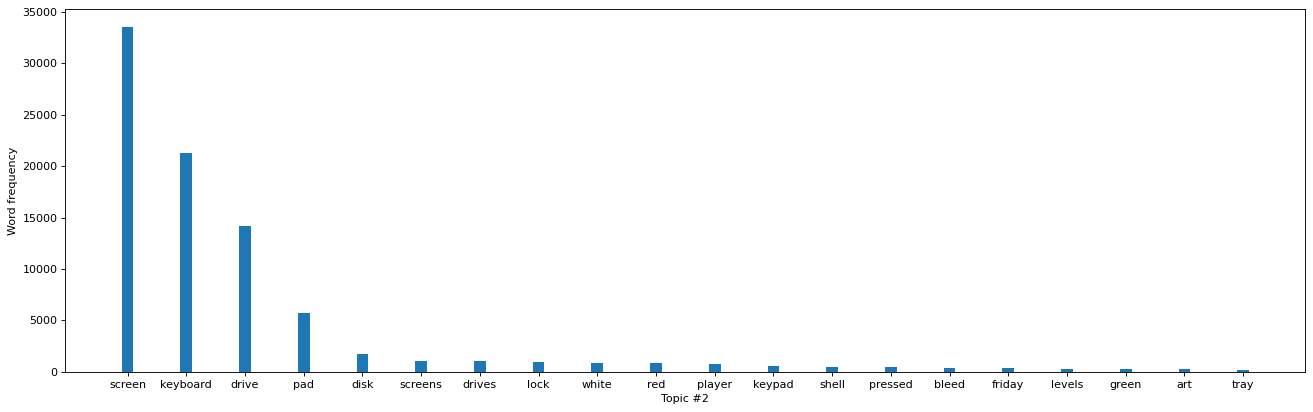

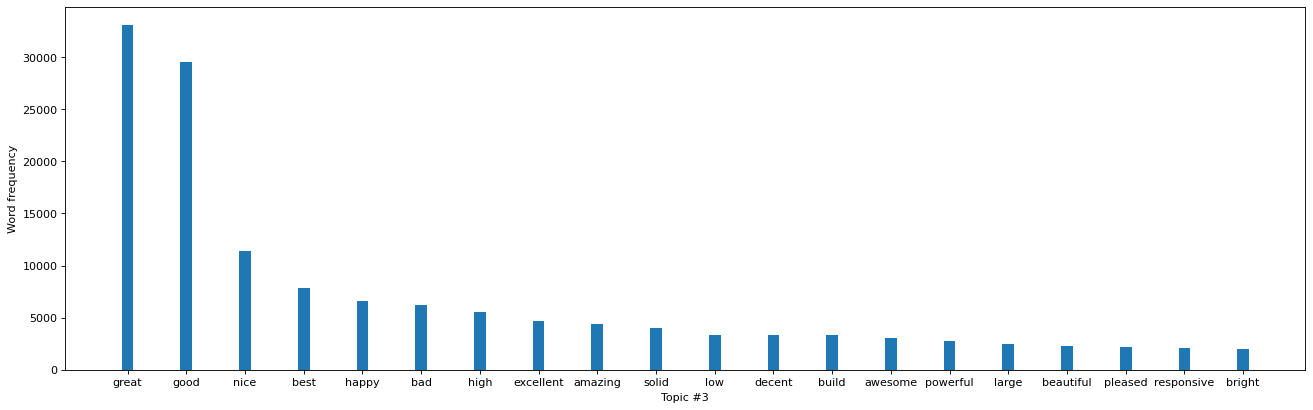

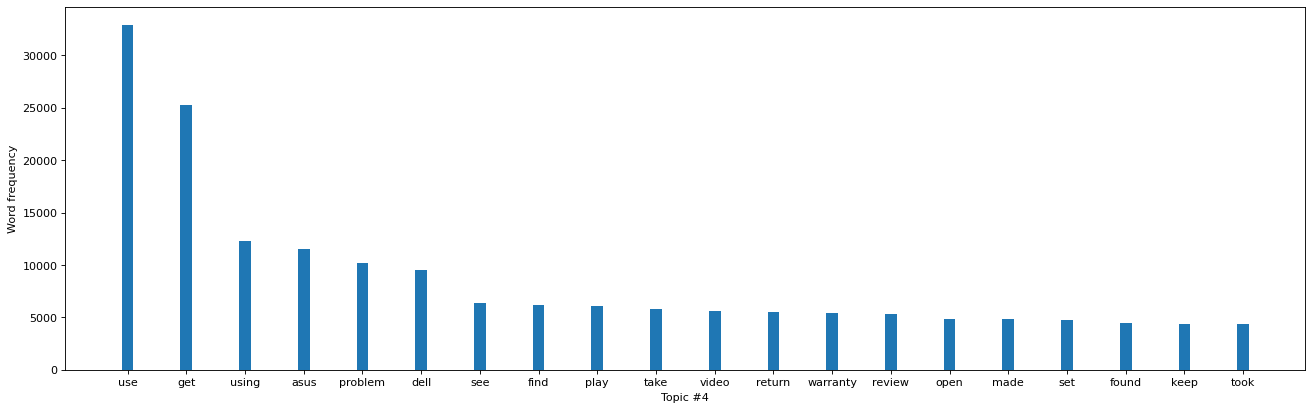

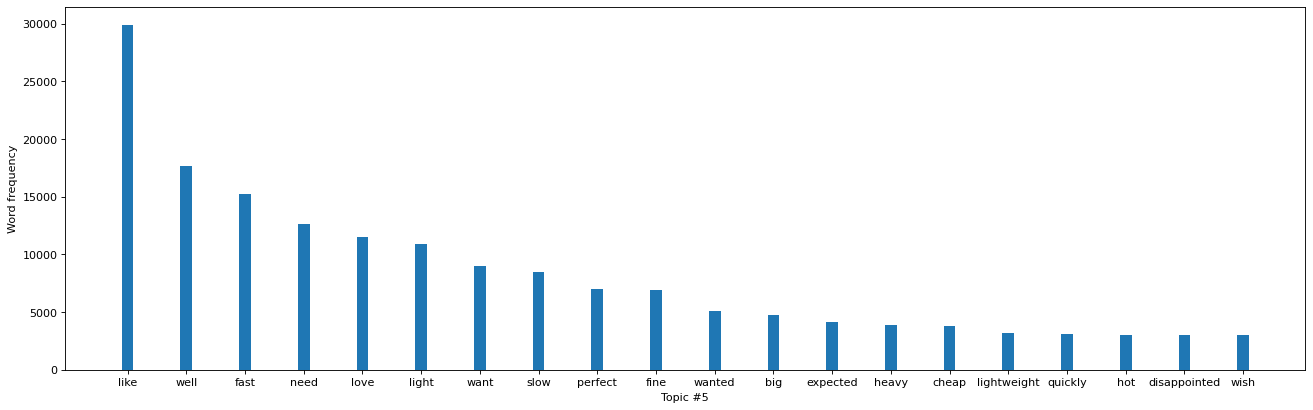

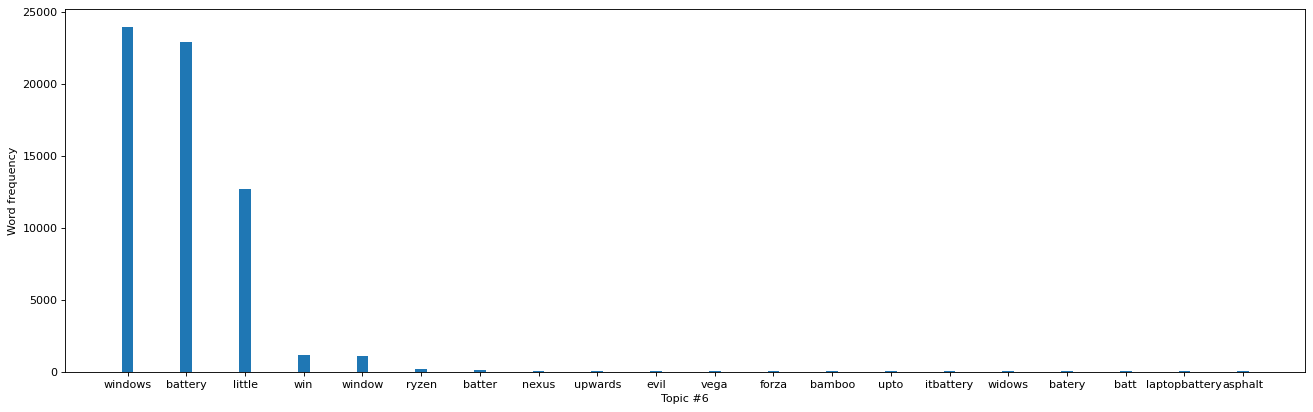

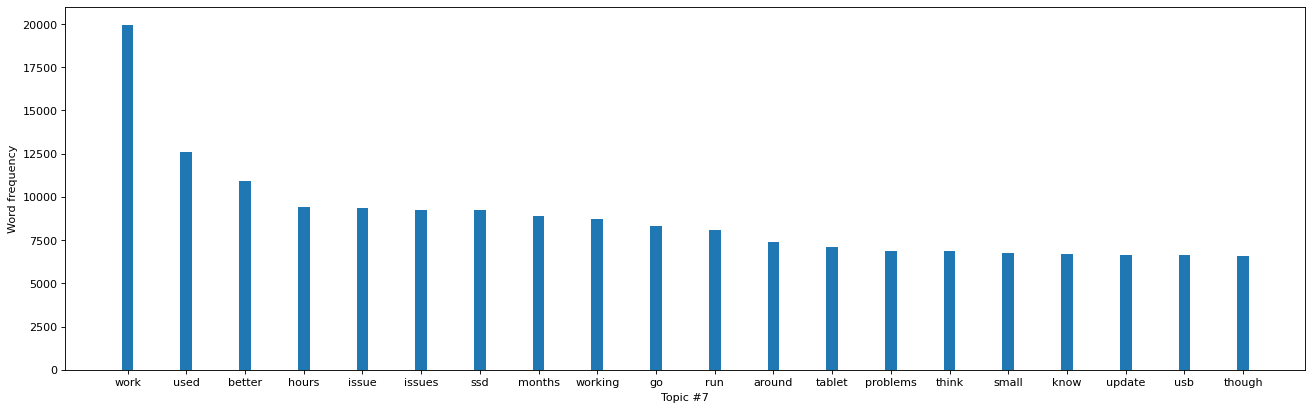

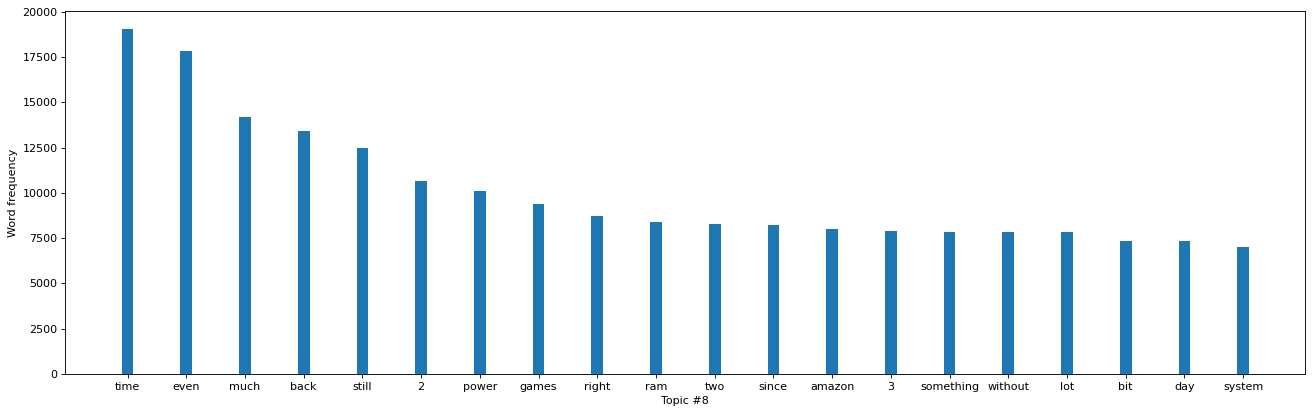

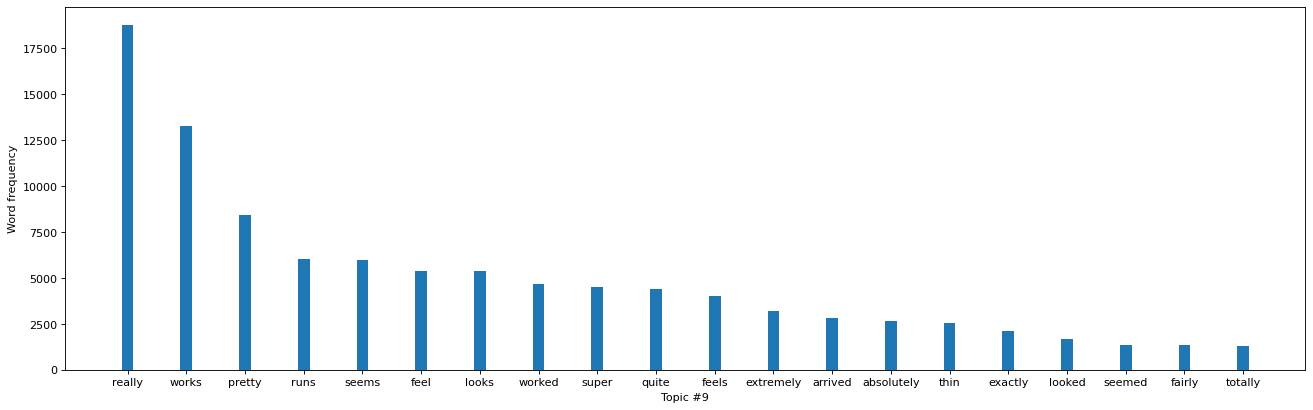

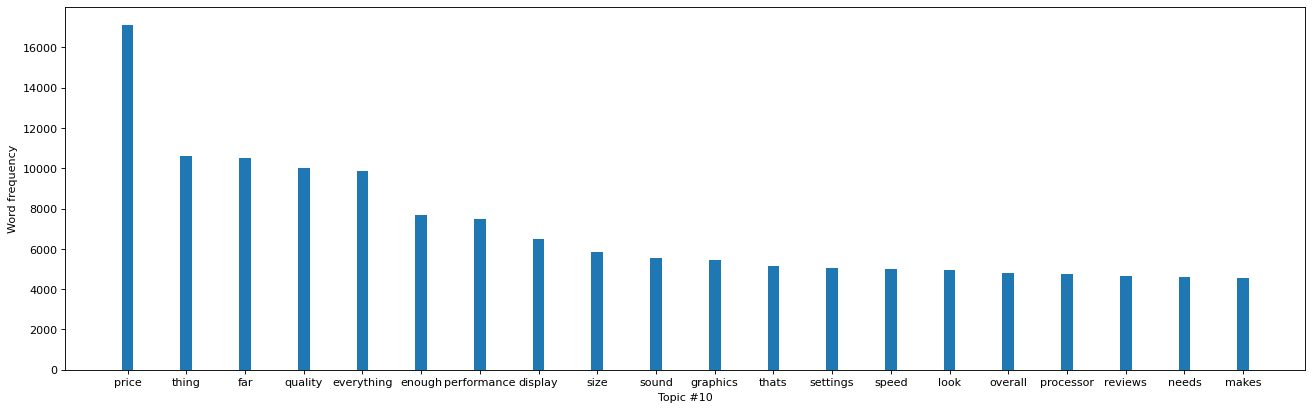

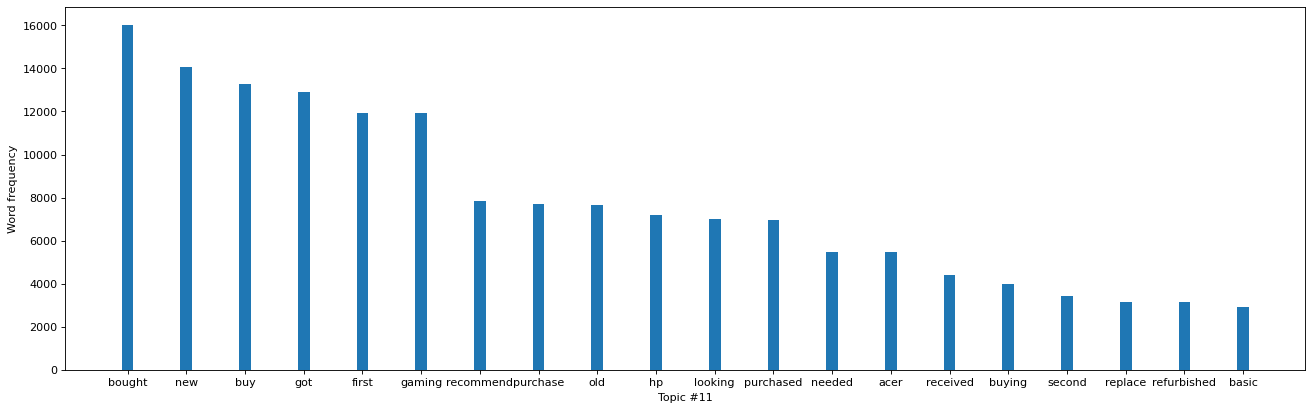

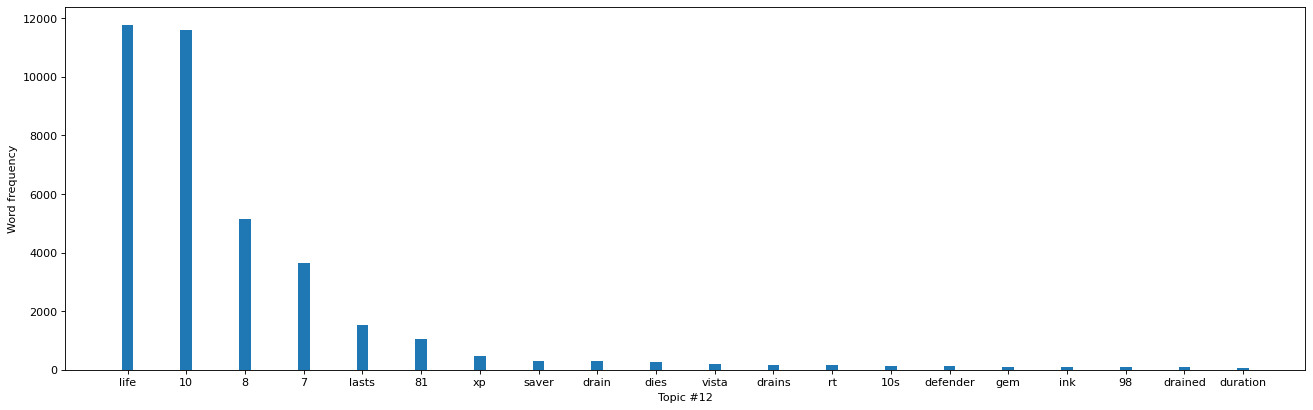

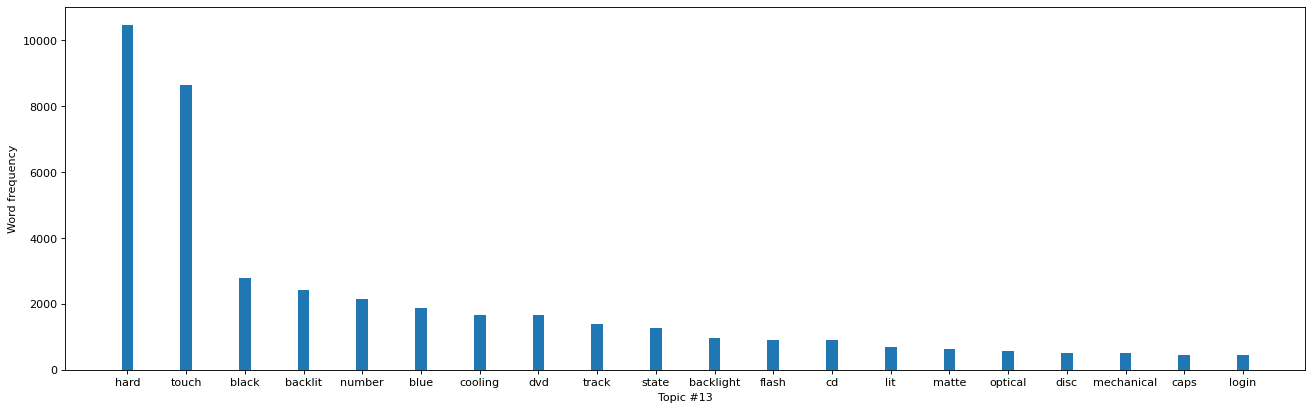

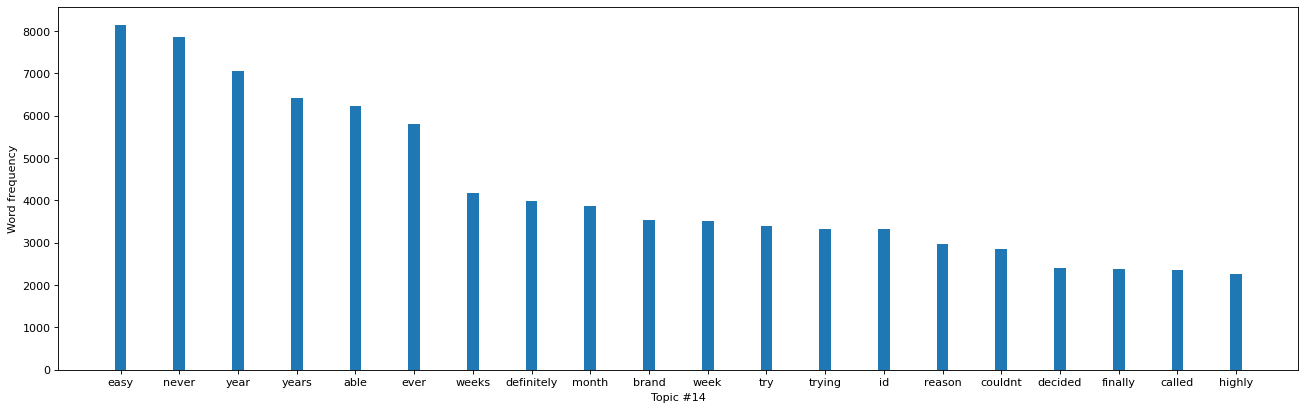

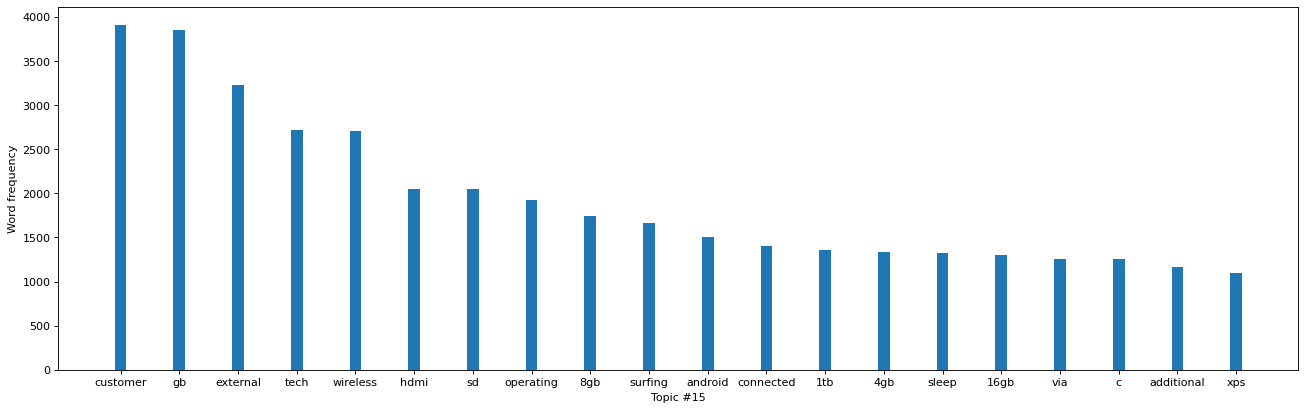

In [26]:
from matplotlib.pyplot import figure

def plot_words_in_topic(topics):
  for i in range(len(topics)):
    figure(figsize=(20, 6), dpi=80)
    y_ticks = []
    x_labels = []

    # print(topics[i][1])
    for key, value in enumerate(topics[i][1]):
      # print(value)
      y_ticks.append(value[1])
      x_labels.append(value[0])

    x_ticks = list(range(1, (len(x_labels) + 1)))
    plt.xticks(x_ticks, x_labels)
    plt.bar(x_ticks, y_ticks, width=.2)
    plt.ylabel('Word frequency')
    plt.xlabel('Topic #' + str(i + 1))
    plt.show()
    print()
    print()
plot_words_in_topic(topics)

# Dendrogram

In [27]:
def cluster_labels(df):
  df1 = df
  df1['row_number'] = df.groupby(['cluster']).cumcount() + 1
  df1 = df1[df1['row_number'] == 1] 
  return df1
cluster_labels(df)

,cluster,word,frequency,row_number
25849,0110,laptop,88049,1
42233,11110,screen,33568,1
35516,101,great,33120,1
19183,0100,use,32929,1
32441,100,like,29913,1
15783,0011,windows,23952,1
14763,00011,work,19957,1
5735,0000,time,19074,1
37831,110,really,18799,1
41302,1110,price,17129,1


In [28]:
class TreeNode:
    def __init__(self, key="", val="", left=None, right=None, parent=None):
        self.key = key
        self.val = val
        self.right = right
        self.left = left
        self.parent = parent

    def __repr__(self):
        return f'k: {self.key}, v: {self.val}'

def get_items(df):
  items = {}
  for index, row in df.iterrows():
    items[row['cluster']] = row['word']
  return items

items = get_items(cluster_labels(df))
root = TreeNode("root")


def get_TreeNode(tree_node, key, value):
    current_node = tree_node
    for i, v in enumerate(key):
        partial_key = key[0:i + 1]
        if v == "0":
            if current_node.right is None:
                current_node.right = TreeNode(key=partial_key, parent=current_node)
            current_node = current_node.right
        else:
            if current_node.left is None:
                current_node.left = TreeNode(key=partial_key, parent=current_node)
            current_node = current_node.left
    current_node.val = value
    current_node.key = key
    return current_node


for key, value in items.items():
    get_TreeNode(root, key, value)


def parent_list_graphviz_str(parents):
    parents = parents[::-1]
    sj = []
    for item in parents:
        if item.val == "":
            sj.append(f'"{item.key}"')
        else:
            sj.append(f'"{item.key}:{item.val}"')
    return ' -> '.join(sj)


def get_parent_list(current):
    parents = [current]
    parent = current
    while parent.parent is not None:
        parents.append(parent.parent)
        parent = parent.parent
    return parents

ranks = {999: []}


def append_to_ranks(ranks, current):
    if current.key == "root":
        return
    if current.left is None and current.right is None:
        ranks[999].append(f'"{current.key}:{current.val}"')
    else:
        if len(current.key) not in ranks:
            ranks[len(current.key)] = []
        ranks[len(current.key)].append(f'"{current.key}"')


graphviz_source = ['strict digraph { node [shape=box]']
graphviz_source.append('graph [splines=ortho]')
stack = [root]
while stack:
    current = stack.pop()
    append_to_ranks(ranks, current)

    if current.val != "":
        parents = get_parent_list(current)
        graphviz_source.append(parent_list_graphviz_str(parents))

    if current.right is not None:
        stack.append(current.right)

    if current.left is not None:
        stack.append(current.left)

for value in sorted(ranks.keys()):
  graphviz_source.append('{rank = same; ' + "; ".join(ranks[value]) + '}')        

for str in graphviz_source:
    print(str)

graphviz_source.append("}")

strict digraph { node [shape=box]
graph [splines=ortho]
"root" -> "1" -> "11" -> "111" -> "1111" -> "11111:hard"
"root" -> "1" -> "11" -> "111" -> "1111" -> "11110:screen"
"root" -> "1" -> "11" -> "111" -> "1110:price"
"root" -> "1" -> "11" -> "110:really"
"root" -> "1" -> "10" -> "101:great"
"root" -> "1" -> "10" -> "100:like"
"root" -> "0" -> "01" -> "011" -> "0111:easy"
"root" -> "0" -> "01" -> "011" -> "0110:laptop"
"root" -> "0" -> "01" -> "010" -> "0101:bought"
"root" -> "0" -> "01" -> "010" -> "0100:use"
"root" -> "0" -> "00" -> "001" -> "0011:windows"
"root" -> "0" -> "00" -> "001" -> "0010:life"
"root" -> "0" -> "00" -> "000" -> "0001" -> "00011:work"
"root" -> "0" -> "00" -> "000" -> "0001" -> "00010:customer"
"root" -> "0" -> "00" -> "000" -> "0000:time"
{rank = same; "1"; "0"}
{rank = same; "11"; "10"; "01"; "00"}
{rank = same; "111"; "011"; "010"; "001"; "000"}
{rank = same; "1111"; "0001"}
{rank = same; "11111:hard"; "11110:screen"; "1110:price"; "110:really"; "101:great"

In [29]:
from graphviz import Source

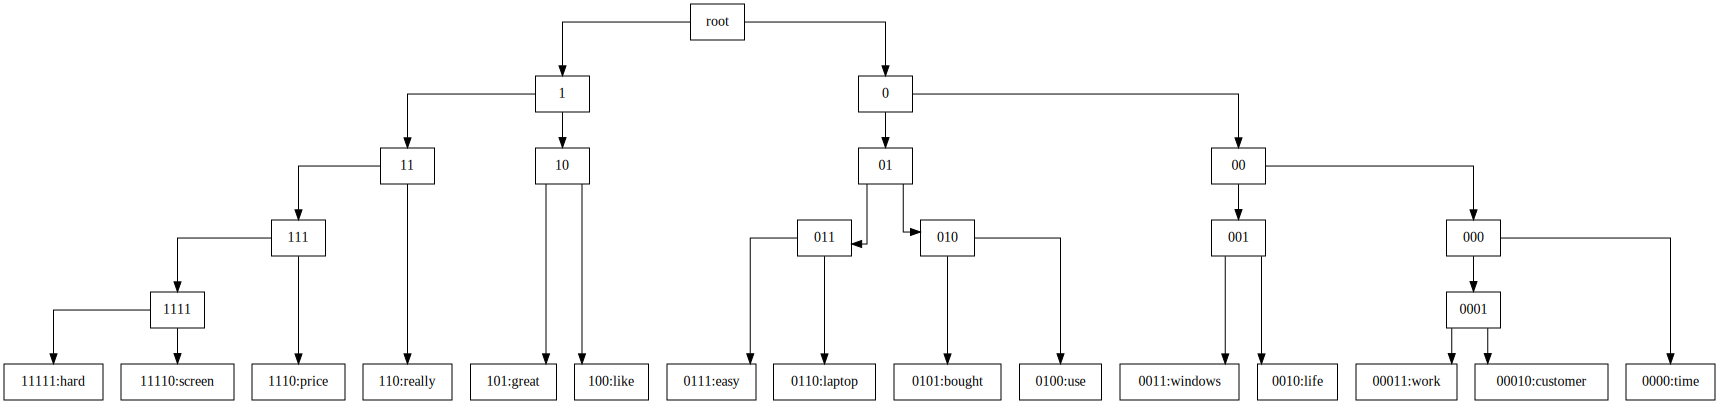

In [30]:
src = Source('\n'.join(graphviz_source))
src